# Import Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from art.utils import load_cifar10
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import SimBA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# Model

In [4]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [5]:
model = create_model()

# Train

In [6]:
classifier = KerasClassifier(
    model=model,
    clip_values=(min_, max_),
    use_logits=False,
    preprocessing=(0.5, 1)
)

In [7]:
classifier.fit(x_train, y_train, nb_epochs=10, verbose=1)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 94us/sample - loss: 1.3659 - accuracy: 0.5094
Epoch 2/10
50000/50000 [==============================] - 3s 66us/sample - loss: 0.8947 - accuracy: 0.6851
Epoch 3/10
50000/50000 [==============================] - 3s 64us/sample - loss: 0.6999 - accuracy: 0.7544
Epoch 4/10
50000/50000 [==============================] - 3s 65us/sample - loss: 0.5382 - accuracy: 0.8115
Epoch 5/10
50000/50000 [==============================] - 3s 66us/sample - loss: 0.3927 - accuracy: 0.8646
Epoch 6/10
50000/50000 [==============================] - 3s 65us/sample - loss: 0.2553 - accuracy: 0.9105
Epoch 7/10
50000/50000 [==============================] - 5s 107us/sample - loss: 0.1529 - accuracy: 0.9470
Epoch 8/10
50000/50000 [==============================] - 4s 70us/sample - loss: 0.0866 - accuracy: 0.9699
Epoch 9/10
50000/50000 [==============================] - 3s 68us/sample - loss: 0.0657 - accuracy: 0.9766
Epoch 10/10
5

# Attack

In [8]:
art_model = KerasClassifier(
    model=model, 
    clip_values=(min_, max_),
    use_logits=False,
    preprocessing=(0.5, 1)
)

In [11]:
simba = SimBA(art_model, epsilon=0.05)

In [12]:
adv_test = simba.generate(x=x_test[:16], y=y_test[:16])

SimBA - sample:   0%|          | 0/16 [00:00<?, ?it/s]

# Results

In [13]:
safe_preds = np.argmax(art_model.predict(x_test[:16]), axis=1)

In [14]:
safe_preds

array([3, 8, 8, 1, 4, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 6])

In [15]:
y_test = np.argmax(y_test[:16], axis=1)

In [19]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

In [20]:
safe_model_scores

{'ACC': 0.8125,
 'PREC': 0.8958333333333333,
 'REC': 0.8125,
 'F1': 0.8333333333333334}

In [21]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [22]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

In [23]:
adv_model_scores

{'ACC': 0.25, 'PREC': 0.21875, 'REC': 0.25, 'F1': 0.22083333333333333}

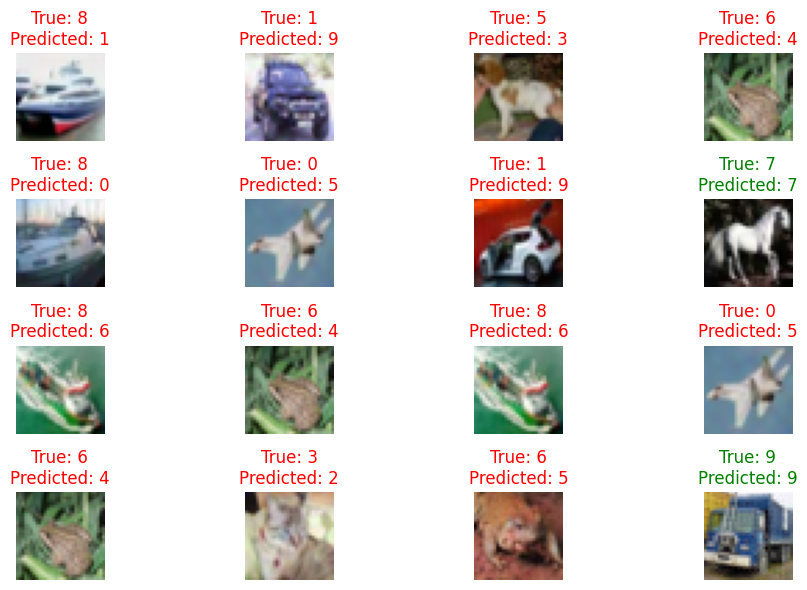

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]], cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()